In [1]:
import os
import shutil
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler, random_split, DataLoader
from torchvision import datasets, transforms, models

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier

import kagglehub


class data_preparation:
    @staticmethod
    def download_and_prepare_data(wolf):
        """
        Prepares the dataset by combining Stanford Dogs dataset and Wolves dataset.
        """
        # Download datasets
        path_stanford_dogs = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")
        path_wolfs = kagglehub.dataset_download("harishvutukuri/dogs-vs-wolves")
        
        # Define directories
        stanford_dogs_src = os.path.join(path_stanford_dogs, "images/Images")
        writable_dir = '/kaggle/working/processed_dataset'
        
        # Create writable directory
        os.makedirs(writable_dir, exist_ok=True)
        
        # Copy Stanford Dogs dataset to writable directory
        for breed_dir in os.listdir(stanford_dogs_src):
            src_dir = os.path.join(stanford_dogs_src, breed_dir)
            dest_dir = os.path.join(writable_dir, breed_dir)  # Each breed becomes a top-level folder
            os.makedirs(dest_dir, exist_ok=True)
            for file_name in os.listdir(src_dir):
                src_path = os.path.join(src_dir, file_name)
                dest_path = os.path.join(dest_dir, file_name)
                if os.path.isfile(src_path):
                    shutil.copy(src_path, dest_path)
        
        # Add wolves dataset if required
        if wolf:
            wolves_src = os.path.join(path_wolfs, "data", "wolves")
            wolf_class_dir = os.path.join(writable_dir, "wolf")  # Wolf becomes a top-level folder
            os.makedirs(wolf_class_dir, exist_ok=True)
            for file_name in os.listdir(wolves_src):
                src_path = os.path.join(wolves_src, file_name)
                dest_path = os.path.join(wolf_class_dir, file_name)
                if os.path.isfile(src_path):
                    shutil.copy(src_path, dest_path)
        
        return writable_dir

    @staticmethod
    def create_sampler(dataset):
        """
        Creates a WeightedRandomSampler for handling class imbalance.

        Args:
            dataset: The dataset for which the sampler is created.

        Returns:
            sampler: A WeightedRandomSampler object.
            weight_df: A DataFrame containing class weights and counts.
        """
        class_counts = Counter(dataset.dataset.targets[i] for i in dataset.indices)
        all_classes = range(len(dataset.dataset.classes))

        for cls in all_classes:
            if cls not in class_counts:
                class_counts[cls] = 0

        class_weights = {cls: 1.0 / count if count > 0 else 0 for cls, count in class_counts.items()}
        sample_weights = [class_weights[dataset.dataset.targets[i]] for i in dataset.indices]
        sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

        weight_df = pd.DataFrame({
            'Class': dataset.dataset.classes,
            'Count': [class_counts[cls] for cls in all_classes],
            'Weight': [class_weights[cls] for cls in all_classes]
        })

        return sampler, weight_df

    @staticmethod
    def get_data(batch_size=128, imbalance_handling=True, wolf=True):
        """
        Prepares the dataset and dataloaders with optional imbalance handling.

        Args:
            batch_size: The batch size for DataLoaders.
            imbalance_handling: Whether to apply imbalance handling with a sampler.

        Returns:
            train_loader, val_loader, test_loader: DataLoaders for training, validation, and testing.
            classes_weights: A DataFrame with class weights and counts.
        """
        # Download and prepare data
        dataset_dir = data_preparation.download_and_prepare_data(wolf)

        # Define transforms
        transform = transforms.Compose([
            transforms.Resize((331, 331)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Prepare datasets
        full_dataset = datasets.ImageFolder(dataset_dir, transform=transform)
        train_size = int(0.7 * len(full_dataset))
        val_size = int(0.15 * len(full_dataset))
        test_size = len(full_dataset) - train_size - val_size
        train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

        # Handle imbalance with a sampler
        if imbalance_handling:
            train_sampler, classes_weights = data_preparation.create_sampler(train_dataset)
            train_loader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                sampler=train_sampler,
                drop_last=True,
                num_workers=2,
                pin_memory=True
            )
        else:
            train_loader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=2,
                pin_memory=True
            )
            classes_weights = None

        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=2,
            pin_memory=True
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=2,
            pin_memory=True
        )

        return train_loader, val_loader, test_loader, classes_weights

    # Prepare data loaders
train_loader, val_loader, test_loader, classes_weights = data_preparation.get_data(batch_size=16, imbalance_handling=True, wolf=True)
# Print class weights and counts
if classes_weights is not None:
    print("Class Weights and Counts:")
    print(classes_weights)
# Check data loaders
for batch_idx, (images, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1} - Images shape: {images.shape}, Labels: {labels}")
    if batch_idx == 2:  # Stop after 3 batches
        break
print("Validation and Test Loaders Check:")
for val_images, val_labels in val_loader:
    print(f"Validation Batch - Images shape: {val_images.shape}, Labels: {val_labels}")
    break
for test_images, test_labels in test_loader:
    print(f"Test Batch - Images shape: {test_images.shape}, Labels: {test_labels}")
    break


Class Weights and Counts:
                             Class  Count    Weight
0              n02085620-Chihuahua    113  0.008850
1       n02085782-Japanese_spaniel    137  0.007299
2            n02085936-Maltese_dog    184  0.005435
3               n02086079-Pekinese    102  0.009804
4               n02086240-Shih-Tzu    146  0.006849
..                             ...    ...       ...
116     n02113978-Mexican_hairless    102  0.009804
117                n02115641-dingo    107  0.009346
118                n02115913-dhole    108  0.009259
119  n02116738-African_hunting_dog    115  0.008696
120                           wolf    691  0.001447

[121 rows x 3 columns]
Batch 1 - Images shape: torch.Size([16, 3, 331, 331]), Labels: tensor([  6,  17,  89,  87, 108,  79,  62,  63,  75,  16,  26,  59,  95,  94,
         51,  51])
Batch 2 - Images shape: torch.Size([16, 3, 331, 331]), Labels: tensor([ 23,  98,   0,  85,  97,  75,  87,  83,  71, 111, 108,  84,   4,  26,
        108,  43])
Batch 

In [2]:
# Fixed function: Returns the pipeline instead of models

def precompute_pca_and_train_xgboost(feature_extractor, train_loader, val_loader, test_loader, device, n_components,num_classes):
    # Extract features and apply PCA
    train_features, train_labels = extract_features(train_loader,feature_extractor,device)
    val_features, val_labels = extract_features(val_loader,feature_extractor,device)
    test_features, test_labels = extract_features(test_loader,feature_extractor,device)

    # Define the pipeline
    pipeline = Pipeline([
        ("pca", PCA(n_components=n_components)),  # PCA for dimensionality reduction
        ("feature_selection", SelectFromModel(XGBClassifier(objective="multi:softmax", num_class=num_classes, eval_metric="mlogloss", device="cuda"))),  # Feature selection
        ("xgb", XGBClassifier(objective="multi:softmax", num_class=num_classes, eval_metric="mlogloss", device="cuda"))  # XGBoost
    ])

    pipeline.fit(train_features, train_labels)

    test_predictions = pipeline.predict(test_features)

    print("XGBoost Metrics:")
    print(f"Accuracy: {accuracy_score(test_labels, test_predictions):.4f}")
    print(f"F1 Score (weighted): {f1_score(test_labels, test_predictions, average='weighted'):.4f}")
    print(f"Precision (weighted): {precision_score(test_labels, test_predictions, average='weighted'):.4f}")
    print(f"Recall (weighted): {recall_score(test_labels, test_predictions, average='weighted'):.4f}")
    
    original_classes = train_loader.dataset.dataset.classes
    processed_classes = [cls.split('-')[-1] for cls in original_classes]  # Use only the part after the last '-'

    cm = confusion_matrix(test_labels, test_predictions)
    fig, ax = plt.subplots(figsize=(25, 25))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=processed_classes)
    disp.plot(ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(num_classes))
    ax.set_xticklabels(processed_classes, rotation=90, fontsize=8)  
    ax.set_yticks(np.arange(num_classes))
    ax.set_yticklabels(processed_classes, fontsize=8)
    
    plt.title("Confusion Matrix", fontsize=22)
    plt.xlabel("Predicted Label", fontsize=18)
    plt.ylabel("True Label", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()


    
    

    # Return the pipeline
    return pipeline




def extract_features(loader,feature_extractor,device):
   all_features, all_labels = [], []
   with torch.no_grad():
       for inputs, labels in tqdm(loader, desc="Extracting Features"):
           inputs = inputs.to(device)
           features = feature_extractor(inputs).detach().cpu().numpy()
           all_features.append(features)
           all_labels.extend(labels.numpy())
   return np.concatenate(all_features, axis=0), np.array(all_labels)

class MultiCNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(MultiCNNFeatureExtractor, self).__init__()

        # Load pretrained models
        self.inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        self.inception_v3.aux_logits = False  # Manually set aux_logits to False

        self.inception_v3.fc = nn.Identity()

        self.inception_resnet_v2 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.inception_resnet_v2.fc = nn.Identity()

        self.nasnet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        self.nasnet.classifier = nn.Identity()

        self.pnasnet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.pnasnet.classifier = nn.Identity()

        # Feature dimensions
        self.feature_dims = {
            "inception_v3": 2048,
            "inception_resnet_v2": 2048,
            "nasnet": 1280,
            "pnasnet": 1024,
        }
        self.total_features = sum(self.feature_dims.values())


    def forward(self, x):

        x_299 = torch.nn.functional.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)

        features_v3 = self.inception_v3(x_299)  # Shape: [batch_size, 2048]
        features_resnet_v2 = self.inception_resnet_v2(x_299)  # Shape: [batch_size, 1536]
        features_nasnet = self.nasnet(x)  # Shape: [batch_size, 4032]
        features_pnasnet = self.pnasnet(x)  # Shape: [batch_size, 4320]
        

        
        # Concatenate all features
        combined_features = torch.cat(
            (features_v3, features_resnet_v2, features_nasnet, features_pnasnet), dim=1
        )  # Shape: [batch_size, total_features]

        return combined_features



class MultiCNNFineTune(nn.Module):
    def __init__(self):
        super(MultiCNNFineTune, self).__init__()
        self.feature_extractor = MultiCNNFeatureExtractor()
        self.classifier = nn.Linear(self.feature_extractor.total_features, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 221MB/s] 
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 152MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 181MB/s]
Epoch 1/50: 100%|██████████| 944/944 [02:32<00:00,  6.19it/s]


Epoch 1: New best model saved with validation loss 0.8268
Epoch 1: Train Loss: 2.2626, Val Loss: 0.8268, Train Acc: 0.6117, Val Acc: 0.8533


Epoch 2/50: 100%|██████████| 944/944 [02:31<00:00,  6.24it/s]


Epoch 2: New best model saved with validation loss 0.5591
Epoch 2: Train Loss: 0.8438, Val Loss: 0.5591, Train Acc: 0.8329, Val Acc: 0.8641


Epoch 3/50: 100%|██████████| 944/944 [02:31<00:00,  6.24it/s]


Epoch 3: New best model saved with validation loss 0.4732
Epoch 3: Train Loss: 0.6195, Val Loss: 0.4732, Train Acc: 0.8638, Val Acc: 0.8764


Epoch 4/50: 100%|██████████| 944/944 [02:31<00:00,  6.24it/s]


Epoch 4: New best model saved with validation loss 0.4333
Epoch 4: Train Loss: 0.5188, Val Loss: 0.4333, Train Acc: 0.8852, Val Acc: 0.8826


Epoch 5/50: 100%|██████████| 944/944 [02:31<00:00,  6.24it/s]


Epoch 5: New best model saved with validation loss 0.4008
Epoch 5: Train Loss: 0.4611, Val Loss: 0.4008, Train Acc: 0.8892, Val Acc: 0.8866


Epoch 6/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 6: New best model saved with validation loss 0.3379
Epoch 6: Train Loss: 0.3794, Val Loss: 0.3379, Train Acc: 0.9068, Val Acc: 0.9008


Epoch 7/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 7: New best model saved with validation loss 0.3170
Epoch 7: Train Loss: 0.3191, Val Loss: 0.3170, Train Acc: 0.9221, Val Acc: 0.8999


Epoch 8/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 8: New best model saved with validation loss 0.2966
Epoch 8: Train Loss: 0.2959, Val Loss: 0.2966, Train Acc: 0.9293, Val Acc: 0.9070


Epoch 9/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 9: New best model saved with validation loss 0.2938
Epoch 9: Train Loss: 0.2729, Val Loss: 0.2938, Train Acc: 0.9376, Val Acc: 0.9079


Epoch 10/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 10: New best model saved with validation loss 0.2819
Epoch 10: Train Loss: 0.2561, Val Loss: 0.2819, Train Acc: 0.9411, Val Acc: 0.9110


Epoch 11/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 11: New best model saved with validation loss 0.2808
Epoch 11: Train Loss: 0.2401, Val Loss: 0.2808, Train Acc: 0.9454, Val Acc: 0.9120


Epoch 12/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 12: No improvement. Early stopping counter: 1/10
Epoch 12: Train Loss: 0.2241, Val Loss: 0.2847, Train Acc: 0.9498, Val Acc: 0.9098


Epoch 13/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 13: New best model saved with validation loss 0.2742
Epoch 13: Train Loss: 0.2110, Val Loss: 0.2742, Train Acc: 0.9554, Val Acc: 0.9116


Epoch 14/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 14: New best model saved with validation loss 0.2701
Epoch 14: Train Loss: 0.1994, Val Loss: 0.2701, Train Acc: 0.9574, Val Acc: 0.9138


Epoch 15/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 15: No improvement. Early stopping counter: 1/10
Epoch 15: Train Loss: 0.1870, Val Loss: 0.2715, Train Acc: 0.9619, Val Acc: 0.9116


Epoch 16/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 16: No improvement. Early stopping counter: 2/10
Epoch 16: Train Loss: 0.1819, Val Loss: 0.2706, Train Acc: 0.9658, Val Acc: 0.9135


Epoch 17/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 17: New best model saved with validation loss 0.2679
Epoch 17: Train Loss: 0.1624, Val Loss: 0.2679, Train Acc: 0.9689, Val Acc: 0.9150


Epoch 18/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 18: New best model saved with validation loss 0.2668
Epoch 18: Train Loss: 0.1584, Val Loss: 0.2668, Train Acc: 0.9705, Val Acc: 0.9126


Epoch 19/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 19: No improvement. Early stopping counter: 1/10
Epoch 19: Train Loss: 0.1520, Val Loss: 0.2708, Train Acc: 0.9731, Val Acc: 0.9113


Epoch 20/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 20: No improvement. Early stopping counter: 2/10
Epoch 20: Train Loss: 0.1419, Val Loss: 0.2718, Train Acc: 0.9758, Val Acc: 0.9135


Epoch 21/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 21: New best model saved with validation loss 0.2657
Epoch 21: Train Loss: 0.1359, Val Loss: 0.2657, Train Acc: 0.9773, Val Acc: 0.9141


Epoch 22/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 22: New best model saved with validation loss 0.2650
Epoch 22: Train Loss: 0.1291, Val Loss: 0.2650, Train Acc: 0.9788, Val Acc: 0.9116


Epoch 23/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 23: No improvement. Early stopping counter: 1/10
Epoch 23: Train Loss: 0.1208, Val Loss: 0.2658, Train Acc: 0.9819, Val Acc: 0.9144


Epoch 24/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 24: No improvement. Early stopping counter: 2/10
Epoch 24: Train Loss: 0.1177, Val Loss: 0.2656, Train Acc: 0.9815, Val Acc: 0.9144


Epoch 25/50: 100%|██████████| 944/944 [08:39<00:00,  1.82it/s]


Epoch 25: New best model saved with validation loss 0.2635
Epoch 25: Train Loss: 0.1166, Val Loss: 0.2635, Train Acc: 0.9802, Val Acc: 0.9163


Epoch 26/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 26: No improvement. Early stopping counter: 1/10
Epoch 26: Train Loss: 0.1071, Val Loss: 0.2655, Train Acc: 0.9850, Val Acc: 0.9135


Epoch 27/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 27: New best model saved with validation loss 0.2622
Epoch 27: Train Loss: 0.1037, Val Loss: 0.2622, Train Acc: 0.9854, Val Acc: 0.9157


Epoch 28/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 28: No improvement. Early stopping counter: 1/10
Epoch 28: Train Loss: 0.0969, Val Loss: 0.2642, Train Acc: 0.9881, Val Acc: 0.9144


Epoch 29/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 29: No improvement. Early stopping counter: 2/10
Epoch 29: Train Loss: 0.0967, Val Loss: 0.2647, Train Acc: 0.9877, Val Acc: 0.9101


Epoch 30/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 30: No improvement. Early stopping counter: 3/10
Epoch 30: Train Loss: 0.0906, Val Loss: 0.2682, Train Acc: 0.9886, Val Acc: 0.9135


Epoch 31/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 31: New best model saved with validation loss 0.2614
Epoch 31: Train Loss: 0.0855, Val Loss: 0.2614, Train Acc: 0.9902, Val Acc: 0.9169


Epoch 32/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 32: No improvement. Early stopping counter: 1/10
Epoch 32: Train Loss: 0.0815, Val Loss: 0.2657, Train Acc: 0.9906, Val Acc: 0.9138


Epoch 33/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 33: No improvement. Early stopping counter: 2/10
Epoch 33: Train Loss: 0.0768, Val Loss: 0.2632, Train Acc: 0.9917, Val Acc: 0.9172


Epoch 34/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 34: No improvement. Early stopping counter: 3/10
Epoch 34: Train Loss: 0.0753, Val Loss: 0.2657, Train Acc: 0.9927, Val Acc: 0.9135


Epoch 35/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 35: No improvement. Early stopping counter: 4/10
Epoch 35: Train Loss: 0.0732, Val Loss: 0.2705, Train Acc: 0.9909, Val Acc: 0.9138


Epoch 36/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 36: No improvement. Early stopping counter: 5/10
Epoch 36: Train Loss: 0.0699, Val Loss: 0.2639, Train Acc: 0.9936, Val Acc: 0.9166


Epoch 37/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 37: No improvement. Early stopping counter: 6/10
Epoch 37: Train Loss: 0.0722, Val Loss: 0.2659, Train Acc: 0.9917, Val Acc: 0.9126


Epoch 38/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 38: No improvement. Early stopping counter: 7/10
Epoch 38: Train Loss: 0.0682, Val Loss: 0.2664, Train Acc: 0.9934, Val Acc: 0.9132


Epoch 39/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 39: No improvement. Early stopping counter: 8/10
Epoch 39: Train Loss: 0.0620, Val Loss: 0.2662, Train Acc: 0.9944, Val Acc: 0.9129


Epoch 40/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 40: No improvement. Early stopping counter: 9/10
Epoch 40: Train Loss: 0.0623, Val Loss: 0.2689, Train Acc: 0.9939, Val Acc: 0.9141


Epoch 41/50: 100%|██████████| 944/944 [08:38<00:00,  1.82it/s]


Epoch 41: No improvement. Early stopping counter: 10/10
Early stopping triggered at epoch 41. Best validation loss: 0.2614
Best model restored.


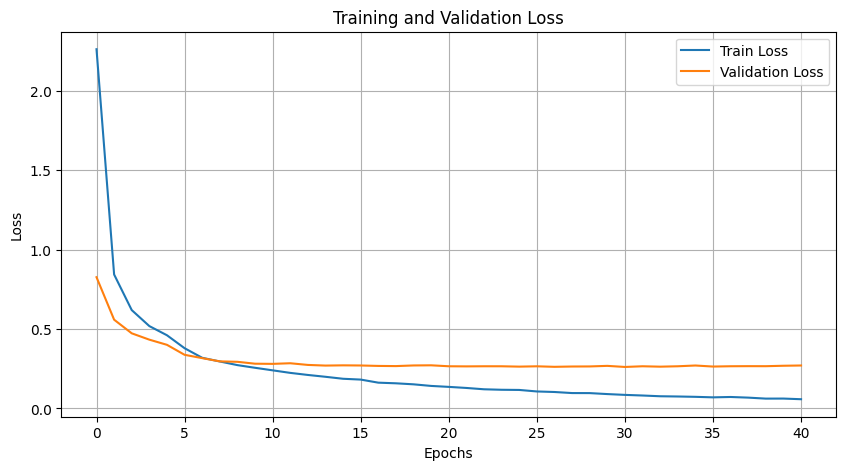

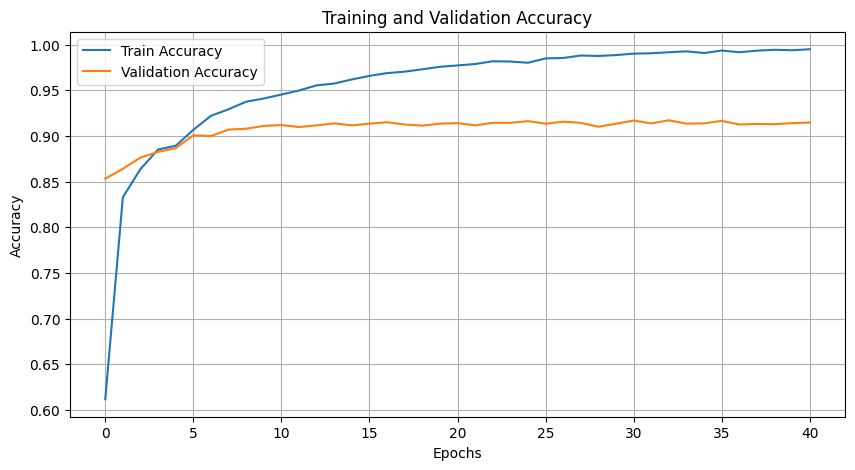

Extracting Features: 100%|██████████| 203/203 [00:32<00:00,  6.27it/s]
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:27:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Metrics:
Accuracy: 0.7668
F1 Score (weighted): 0.7663
Precision (weighted): 0.7773
Recall (weighted): 0.7668


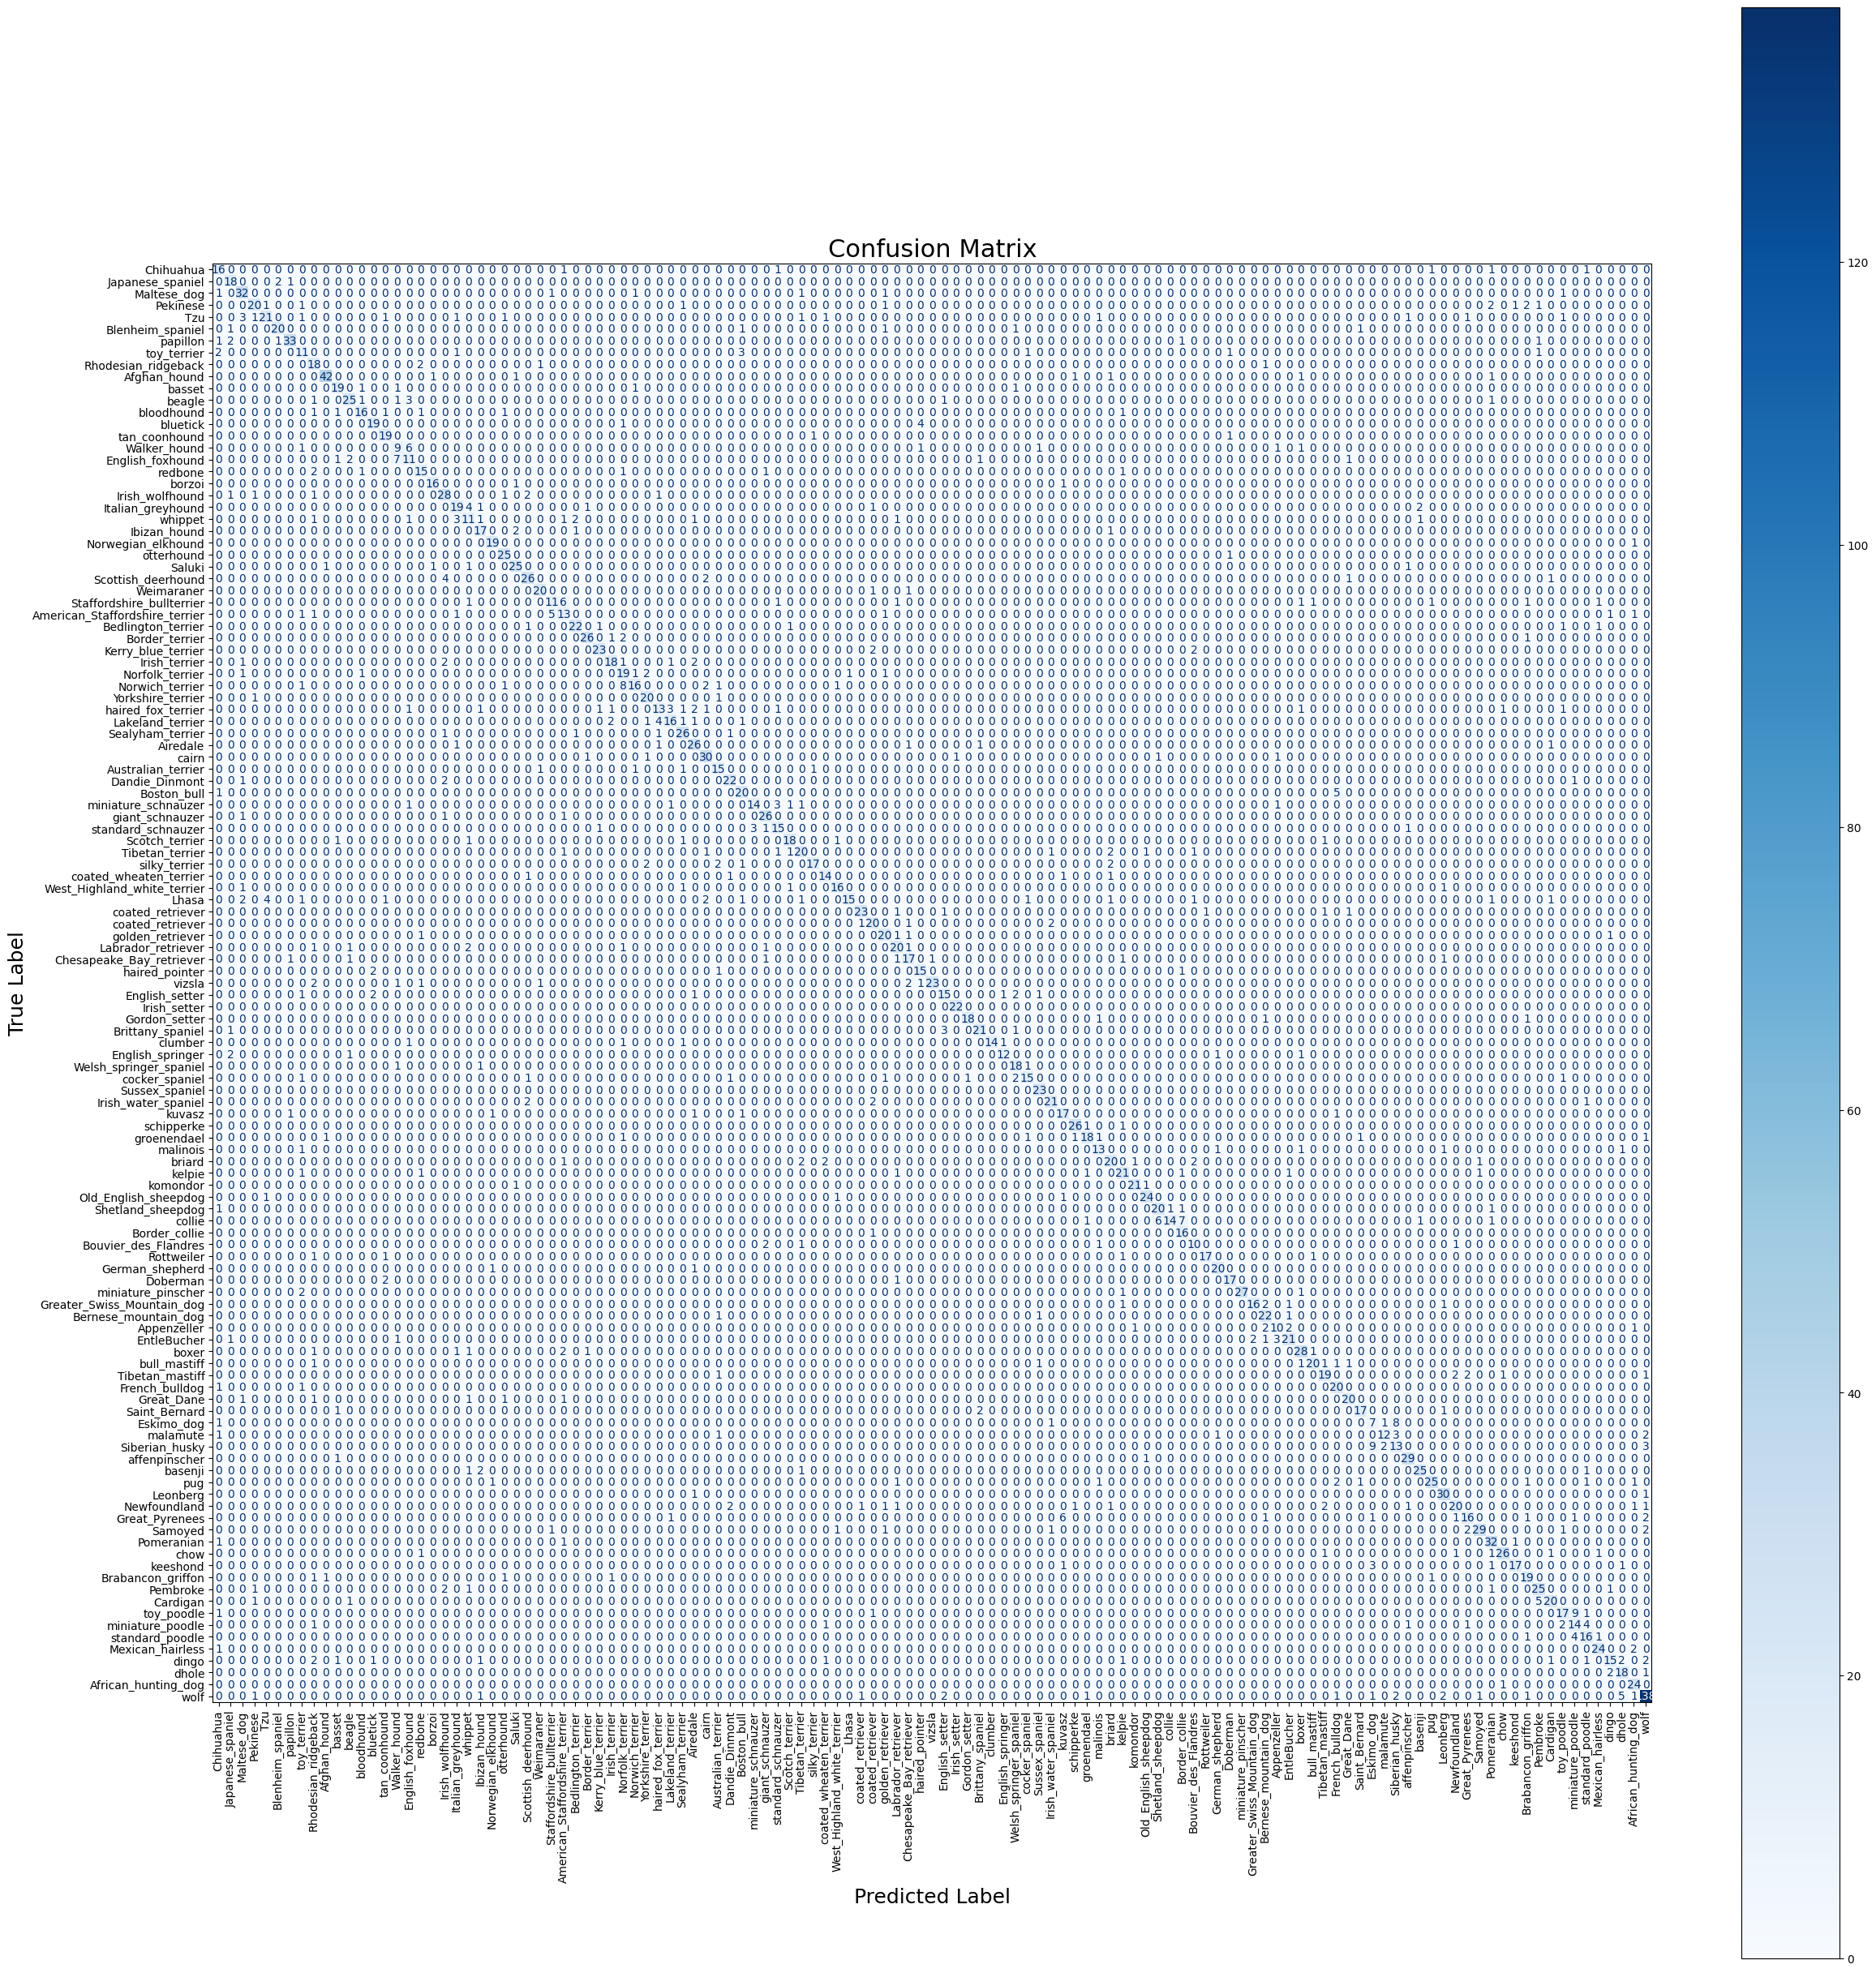

In [3]:

device = "cuda"
num_classes = 121  
from torch.amp import GradScaler, autocast

scaler = GradScaler()  # Initialize the gradient scaler for mixed precision training

fine_tune_model = MultiCNNFineTune().to(device)
optimizer = optim.SGD(fine_tune_model.parameters(), lr=0.001, momentum=0.9)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 
criterion = nn.CrossEntropyLoss()

history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

patience = 10  
best_val_loss = float("inf")  
early_stopping_counter = 0  
best_model_state = None  

for param in fine_tune_model.feature_extractor.parameters():
    param.requires_grad = False

epochs = 50  
for epoch in range(epochs):

    if epoch == 5:  
        for param in fine_tune_model.feature_extractor.parameters():
            param.requires_grad = True
        optimizer = optim.SGD(fine_tune_model.parameters(), lr=1e-4, momentum=0.9)  # Smaller LR for fine-tuning


    
    fine_tune_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        
        with autocast(device_type=device):  
            outputs = fine_tune_model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)  
        scaler.update()  
        
        running_loss += loss.item() * inputs.size(0)  
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)

    # Validation loop
    fine_tune_model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = fine_tune_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)  # Scale by batch size
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_accuracy = val_correct / val_total

    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = fine_tune_model.state_dict()  
        early_stopping_counter = 0  
        print(f"Epoch {epoch+1}: New best model saved with validation loss {val_loss:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Epoch {epoch+1}: No improvement. Early stopping counter: {early_stopping_counter}/{patience}")


    if early_stopping_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}. Best validation loss: {best_val_loss:.4f}")
        break


    scheduler.step()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


fine_tune_model.load_state_dict(best_model_state)
print("Best model restored.")


plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history["train_accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


feature_extractor = fine_tune_model.feature_extractor
feature_extractor.eval()



pipeline_model = precompute_pca_and_train_xgboost(
    feature_extractor=fine_tune_model.feature_extractor,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    n_components=5000,
    num_classes=num_classes,
)








